# Electricity Load Forecasting with LSTM - Multi Horizon Time Series Approach

This notebook builds and evaluates a multi-horizon LSTM model to forecast electricity load up to 24 hours ahead.  
It follows the same methodological framework as the Random Forest notebook, including consistent data preparation, scaling, and evaluation logic.  
The model leverages sequential dependencies within the time series to improve short-term forecasting accuracy.

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
import keras_tuner as kt
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Loading the Data

In [2]:
interim_folder = "../data/processed"

train_val_df = pd.read_csv(os.path.join(interim_folder, "train_val_df.csv"), sep=";", decimal=",")
test_df      = pd.read_csv(os.path.join(interim_folder, "test_df.csv"), sep=";", decimal=",")

train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"]      = pd.to_datetime(test_df["timestamp"])

print(f"Train/Val shape: {train_val_df.shape}")
print(f"Test shape:      {test_df.shape}")

train_val_df.head(1)

Train/Val shape: (17517, 14)
Test shape:      (8783, 14)


,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_6,lag_24,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2022-01-01 01:00:00,41535.75,43915.5,45616.75,47461.5,55785.75,43679.5,41509.0,49242.25,54252.25,44569.25,1,5,1


## Data Preparation
The electricity load (load_MWh) is defined as the target variable, while all non-temporal columns serve as model input features. The data is separated into training/validation and test sets accordingly.
To enable multi-step time series forecasting, the input data is transformed into fixed-length sequences. Each training sample consists of the previous 24 hourly observations (n_input = 24) used to predict the subsequent 24 hours (n_output = 24). The target variable is standardized using a StandardScaler fitted exclusively on the training and validation data to prevent information leakage. The same scaling parameters are then applied to the test targets. Input–output sequences are generated accordingly for both the training/validation set and the test set.

In [3]:
target_col = "load_MWh"
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", target_col]]

X_trainval = train_val_df[feature_cols].values
y_trainval = train_val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print(f"Number of features: {len(feature_cols)}")

Number of features: 12


In [4]:
n_input, n_output = 24, 24

def create_sequences_fixed(X, y, n_input, n_output):
    Xs, ys = [], []
    for i in range(len(X) - n_input - n_output + 1):
        Xs.append(X[i:i+n_input, :])
        ys.append(y[i+n_input:i+n_input+n_output])
    return np.array(Xs), np.array(ys)

# X scaling (fit only on train/val)
x_scaler = StandardScaler()
X_trainval_scaled = x_scaler.fit_transform(X_trainval)
X_test_scaled     = x_scaler.transform(X_test)

# y scaling (fit only on train/val)
y_scaler = StandardScaler()
y_trainval_scaled_y = y_scaler.fit_transform(y_trainval.reshape(-1, 1)).flatten()
y_test_scaled_y     = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# sequences with scaled X and scaled y
X_train_seq, y_train_seq = create_sequences_fixed(X_trainval_scaled, y_trainval_scaled_y, n_input, n_output)
X_test_seq,  y_test_seq  = create_sequences_fixed(X_test_scaled,     y_test_scaled_y,     n_input, n_output)

print("Train sequences:", X_train_seq.shape, y_train_seq.shape)
print("Test sequences: ", X_test_seq.shape,  y_test_seq.shape)
print("y_train_seq mean/std:", y_train_seq.mean(), y_train_seq.std())


Train sequences: (17470, 24, 12) (17470, 24)
Test sequences:  (8736, 24, 12) (8736, 24)
y_train_seq mean/std: 0.002307584923298454 0.9999768733639445


In [ ]:
## Chronological Train/Val Split for Tuning (last 10% of TRAIN sequences)
val_fraction = 0.1
val_size = int(len(X_train_seq) * val_fraction)

X_train_tune = X_train_seq[:-val_size]
y_train_tune = y_train_seq[:-val_size]

X_val_tune = X_train_seq[-val_size:]
y_val_tune = y_train_seq[-val_size:]

print("Tune Train:", X_train_tune.shape, y_train_tune.shape)
print("Tune Val:  ", X_val_tune.shape, y_val_tune.shape)

Tune Train: (15723, 24, 12) (15723, 24)
Tune Val:   (1747, 24, 12) (1747, 24)


## Building the LSTM Model

### 1. Hyperparameter Tuning

A multi-step LSTM model is constructed using a single recurrent layer followed by a fully connected output structure. The number of LSTM units, dropout rates, size of the dense layer, and the learning rate are treated as tunable hyperparameters. Hyperparameter optimization is performed using the Hyperband algorithm, which efficiently explores the search space by allocating more training resources to promising configurations. The model is trained with the Adam optimizer and mean squared error as the loss function. Early stopping and learning rate reduction are applied based on validation loss to improve convergence and prevent overfitting. All tuning runs preserve the temporal order of the data by disabling random shuffling.

After hyperparameter tuning, the best-performing LSTM model is selected based on the lowest validation loss. The model is then used to generate predictions on the validation set. Since the model was trained on standardized target values, the predicted outputs and the corresponding validation targets are transformed back to their original scale (MWh) using the inverse transformation of the target scaler. Finally, the model’s predictive performance is evaluated in real-world units using the root mean squared error (RMSE) and the mean absolute percentage error (MAPE).

In [6]:
def build_lstm_model(hp):
    units = hp.Int("lstm_units", 64, 256, step=32)
    lstm_dropout = hp.Float("lstm_dropout", 0.0, 0.3, step=0.05)
    rec_dropout  = hp.Choice("recurrent_dropout", [0.0, 0.1])
    dense_units  = hp.Int("dense_units", 32, 128, step=16)
    dense_dropout = hp.Float("dense_dropout", 0.0, 0.3, step=0.05)
    lr = hp.Float("learning_rate", 5e-5, 5e-3, sampling="log")

    model = Sequential([
        Input(shape=(n_input, X_train_seq.shape[2])),
        LSTM(
            units,
            activation="tanh",
            dropout=lstm_dropout,
            recurrent_dropout=rec_dropout
        ),
        Dense(dense_units, activation="relu"),
        Dropout(dense_dropout),
        Dense(n_output)
    ])

    opt = Adam(learning_rate=lr, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=["mae"]
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    build_lstm_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="../tuner_results",
    project_name="lstm_hyperband_fixed",
    overwrite=True,
    executions_per_trial=2
)

callbacks_tune = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, min_lr=1e-7)
]

tuner.search(
    X_train_tune, y_train_tune,
    validation_data=(X_val_tune, y_val_tune),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_tune,
    verbose=1,
    shuffle=False
)

Trial 90 Complete [00h 21m 21s]
val_loss: 0.08286888152360916

Best val_loss So Far: 0.07393759861588478
Total elapsed time: 03h 54m 53s


In [8]:
tuner = kt.Hyperband(
    build_lstm_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="../tuner_results",
    project_name="lstm_hyperband_fixed",
    overwrite=False
)
tuner.reload()

Reloading Tuner from ../tuner_results/lstm_hyperband_fixed/tuner0.json


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

{'lstm_units': 192,
 'lstm_dropout': 0.0,
 'recurrent_dropout': 0.1,
 'dense_units': 112,
 'dense_dropout': 0.15000000000000002,
 'learning_rate': 0.0001404189255664286,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

### 2. Validation of the Tuned LSTM Model
The best-performing LSTM model obtained from hyperparameter tuning is evaluated on the validation set. Model predictions and corresponding target values are transformed back to their original scale (MWh), and performance is assessed using RMSE and MAPE in real units.

In [ ]:
# Compute predictions on validation set using the best model
best_model = tuner.get_best_models(1)[0]

# Predict (scaled)
val_preds_scaled = best_model.predict(X_val_tune, verbose=0)

# Inverse scaling
val_preds = y_scaler.inverse_transform(
    val_preds_scaled.reshape(-1, 1)
).flatten()

y_val_true = y_scaler.inverse_transform(
    y_val_tune.reshape(-1, 1)
).flatten()

# Metrics in real units
val_rmse = np.sqrt(mean_squared_error(y_val_true, val_preds))
val_mape = mean_absolute_percentage_error(y_val_true, val_preds) * 100

print(f"[TUNING VAL | REAL] RMSE: {val_rmse:.2f} MWh")

[TUNING VAL | REAL] RMSE: 2571.99 MWh


### 3. Selection and Reconstruction of the Final LSTM Model
After completing the hyperparameter tuning process, the best-performing hyperparameter configuration is retrieved. Using this optimal configuration, a new LSTM model is reconstructed from scratch. This ensures that the final model architecture reflects the tuning results while allowing training on the full dataset.

In [ ]:
# Retrieve the best-performing hyperparameter configuration
best_hps = tuner.get_best_hyperparameters(1)[0]

In [12]:
best_hps.values

{'lstm_units': 192,
 'lstm_dropout': 0.0,
 'recurrent_dropout': 0.1,
 'dense_units': 112,
 'dense_dropout': 0.15000000000000002,
 'learning_rate': 0.0001404189255664286,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

### Key Findings – Hyperparameter Search (LSTM)

- The optimal **LSTM configuration** corresponds to a **high-capacity recurrent architecture**, with **192 LSTM units** selected as the best-performing setting. This indicates that a rich internal state representation is beneficial for capturing complex temporal dependencies in electricity load forecasting.

- The tuning process favored **minimal but non-zero regularization**, with **no standard dropout** and a **small recurrent dropout (0.1)**. This suggests that the available training data provides sufficient implicit regularization, while a slight constraint on the recurrent connections helps stabilize training without impairing temporal information flow.

- A comparatively large **dense layer with 112 units** was selected, highlighting the importance of an expressive mapping from the learned sequence representation to the **multi-step (24-hour) output space**.

- The optimal **learning rate (≈ 1.4 × 10⁻⁴)** lies in the lower range of the tested values, reflecting the need for **stable and gradual convergence** when training high-capacity recurrent models.

- No indications of overfitting were observed during tuning, as evidenced by **smooth validation loss behavior** despite only **moderate regularization**, suggesting good generalization across forecast horizons.

- Overall, the tuning results point to a **well-balanced and robust LSTM architecture** that effectively captures short-term temporal dynamics while maintaining stable generalization performance over the full 24-hour forecasting horizon.



### 4. Training the Final Tuned LSTM Model

The final LSTM model is trained using the optimal hyperparameters on the chronologically ordered training data, with a validation subset reserved for monitoring convergence. Early stopping and adaptive learning rate scheduling are applied to prevent overfitting. After training, the model and the corresponding feature and target scalers are saved for subsequent evaluation and reproducibility.

In [13]:
# Final model from best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
final_model = tuner.hypermodel.build(best_hps)

callbacks_final = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, min_lr=1e-7)
]

val_fraction_final = 0.1
val_size_final = int(len(X_train_seq) * val_fraction_final)

X_train_final = X_train_seq[:-val_size_final]
y_train_final = y_train_seq[:-val_size_final]
X_val_final   = X_train_seq[-val_size_final:]
y_val_final   = y_train_seq[-val_size_final:]

history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_final,
    shuffle=False,
    verbose=1
)

os.makedirs("../models/LSTM", exist_ok=True)
final_model_path = "../models/LSTM/lstm_multistep_model_tuned.keras"
final_model.save(final_model_path)

# Save scalers
joblib.dump(x_scaler, "../models/LSTM/x_scaler.joblib")
joblib.dump(y_scaler, "../models/LSTM/y_scaler.joblib")

print("Final tuned LSTM model saved:", final_model_path)

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.8131 - mae: 0.7119 - val_loss: 0.3470 - val_mae: 0.4540 - learning_rate: 1.4042e-04
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.3260 - mae: 0.4274 - val_loss: 0.2360 - val_mae: 0.3749 - learning_rate: 1.4042e-04
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.2317 - mae: 0.3574 - val_loss: 0.1772 - val_mae: 0.3285 - learning_rate: 1.4042e-04
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.1836 - mae: 0.3180 - val_loss: 0.1504 - val_mae: 0.3048 - learning_rate: 1.4042e-04
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.1656 - mae: 0.3005 - val_loss: 0.1370 - val_mae: 0.2930 - learning_rate: 1.4042e-04
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 0.1475 - mae: 0.2835 - val_loss: 0.1270 - val_mae: 0.2823 - learning_rate: 1.4042e-04
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.1352 - mae: 0.2724 - val_loss: 0.1179 - val_mae:

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 192)            │       157,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 112)            │        21,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         2,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,306 (2.08 MB)

 Trainable params: 181,768 (710.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 363,538 (1.39 MB)

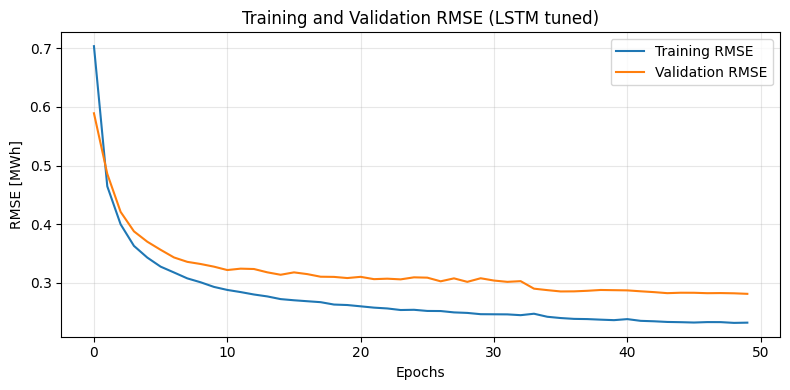

In [14]:
# Training Curves (RMSE)
plt.figure(figsize=(8,4))
plt.plot(np.sqrt(history.history["loss"]), label="Training RMSE")
plt.plot(np.sqrt(history.history["val_loss"]), label="Validation RMSE")
plt.title("Training and Validation RMSE (LSTM tuned)")
plt.xlabel("Epochs")
plt.ylabel("RMSE [MWh]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Key Findings – Training and Validation RMSE (LSTM)

- Both **training and validation RMSE decrease rapidly during the initial epochs**, indicating fast learning of dominant short-term load patterns and effective exploitation of temporal structure early in training.

- After this initial phase, the **validation RMSE continues to decrease gradually and smoothly**, suggesting stable convergence without pronounced oscillations or optimization instability.

- The **gap between training and validation RMSE remains moderate and largely stable** throughout the training process, providing no strong indication of overfitting despite the relatively high model capacity.

- Minor fluctuations in the **validation RMSE during the mid-training phase** are observable and are typical for neural network optimization, particularly in recurrent architectures, and do not indicate unstable training behavior.

- Toward the later epochs, the **validation curve increasingly flattens**, while the training RMSE continues to decrease slightly, indicating that the model approaches a performance plateau and that additional training yields diminishing generalization gains.

- Overall, the learning curves demonstrate **well-controlled and stable training dynamics**, confirming that the selected architecture and hyperparameters lead to a robust and well-generalizing LSTM model.


### 5. Testing on Future Data
The final tuned LSTM model is evaluated on the test set using a rolling multi-horizon forecasting strategy. At each evaluation step, the model uses the previous 24 hours as input to predict the next 24 hours of electricity load. Predictions are generated in a rolling manner with preserved temporal context, ensuring comparability with the Random Forest baseline. All model outputs are transformed back to real units (MWh), and overall as well as horizon-specific error metrics are computed.

In [ ]:
model = load_model(final_model_path)
print("Tuned model loaded successfully.")

def lstm_eval_rolling_rf_aligned(
    model,
    X_train_scaled, X_test_scaled,
    y_train, y_test,
    y_scaler,
    n_input=24, n_output=24,
    step=24
):
    """
    Rolling evaluation aligned with the RF setup:

    Forecast origin at time t (index = start).
    - Input uses the last n_input timesteps ending at t: X_all[start-n_input+1 : start+1]
    - Truth is y at t+1 .. t+n_output: y_all[start+1 : start+1+n_output]
    - Predictions are inverse-transformed to MWh.
    """
    # Combine train+test to preserve context
    X_all = np.vstack([X_train_scaled, X_test_scaled])
    y_all = np.concatenate([y_train, y_test]).astype(float)

    test_start = len(X_train_scaled)          # first index belonging to test in X_all
    test_end   = len(X_all)

    all_preds, all_truth = [], []
    errors_by_h = {h: [] for h in range(1, n_output + 1)}

    # start is the forecast origin t
    # Need: (start - n_input + 1) >= 0  AND  (start + 1 + n_output) <= len(y_all)
    for start in range(test_start, test_end - (n_output + 1), step):
        if start - n_input + 1 < 0:
            continue

        # Input window ends at t (inclusive): length n_input
        X_input = X_all[start - n_input + 1 : start + 1, :][None, ...]  # (1, 24, n_features)

        # Truth block is t+1 .. t+24 (RF comparable)
        y_true = y_all[start + 1 : start + 1 + n_output]                # (24,) MWh

        # Predict in scaled space, then inverse-transform to MWh
        y_pred_scaled = model.predict(X_input, verbose=0)[0]             # (24,) scaled
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten().astype(float)  # (24,) MWh

        all_preds.append(y_pred)
        all_truth.append(y_true)

        for h in range(n_output):
            errors_by_h[h + 1].append(y_true[h] - y_pred[h])

    # Flatten to 1D arrays
    if len(all_truth) == 0:
        print("No rolling windows were evaluated (check test length / step / n_input / n_output).")
        return np.array([]), np.array([]), np.full(n_output, np.nan), np.full(n_output, np.nan), errors_by_h

    all_preds = np.concatenate(all_preds)
    all_truth = np.concatenate(all_truth)

    # Overall metrics
    total_rmse = np.sqrt(np.mean((all_truth - all_preds) ** 2))
    denom = np.clip(np.abs(all_truth), 1e-6, None)
    total_mape = np.mean(np.abs((all_truth - all_preds) / denom)) * 100

    # Per-horizon metrics (aligned horizon slicing)
    rmse_per_h, mape_per_h = [], []
    for h in range(1, n_output + 1):
        e = np.array(errors_by_h[h], dtype=float)
        if len(e) == 0:
            rmse_per_h.append(np.nan)
            mape_per_h.append(np.nan)
            continue

        rmse_per_h.append(np.sqrt(np.mean(e ** 2)))

        # Truth for horizon h corresponds to every n_output-th element starting at (h-1)
        truth_h = all_truth[h - 1 :: n_output][: len(e)]
        denom_h = np.clip(np.abs(truth_h), 1e-6, None)
        mape_per_h.append(np.mean(np.abs(e) / denom_h) * 100)

    rmse_per_h = np.array(rmse_per_h)
    mape_per_h = np.array(mape_per_h)

    print(f"TEST (Rolling) RMSE: {total_rmse:.2f} MWh")
    print(f"TEST (Rolling) MAPE: {total_mape:.2f}%")

    return all_preds, all_truth, rmse_per_h, mape_per_h, errors_by_h


preds, truth, rmse_h, mape_h, errors_h = lstm_eval_rolling_rf_aligned(
    model,
    X_trainval_scaled,
    X_test_scaled,
    y_trainval,
    y_test,
    y_scaler=y_scaler,
    n_input=n_input,
    n_output=n_output,
    step=24
)

Tuned model loaded successfully.
TEST (Rolling) RMSE: 2409.28 MWh
TEST (Rolling) MAPE: 3.07%


### Key Findings – Test Performance

- The tuned LSTM model achieves a **low rolling test RMSE of 2409.28 MWh**, indicating high absolute forecasting accuracy under realistic test conditions.

- A **MAPE of 3.07%** confirms strong relative accuracy and reliable performance across different load levels.

- The rolling evaluation setup demonstrates **robust out-of-sample generalization**, as forecasts are generated without access to future information.

- Overall, the results confirm that the tuned LSTM provides **accurate and stable 24-hour ahead forecasts**, suitable for practical short-term load forecasting.

## Visualization of the Model Performance

### 1. Daily Average Electricity Load: Actual vs Predicted

This section compares the predicted and actual electricity load on the test dataset.
Hourly predictions are aggregated to daily averages to visualize overall forecast accuracy and capture long-term trends.
The plot illustrates how closely the Random Forest models reproduce real load patterns throughout the test year, providing an intuitive check of model performance and temporal consistency.

In [16]:
# Reconstruct timestamps aligned with rolling RF-style evaluation
origin_idx = list(
    range(
        len(X_trainval_scaled),
        len(X_trainval_scaled) + len(X_test_scaled) - (n_output + 1),
        24
    )
)

timestamps = []
for start in origin_idx:
    test_start_idx = start - len(X_trainval_scaled)
    timestamps.extend(
        test_df["timestamp"]
        .iloc[test_start_idx + 1 : test_start_idx + 1 + n_output]
        .tolist()
    )

# Sanity check
assert len(timestamps) == len(truth) == len(preds)


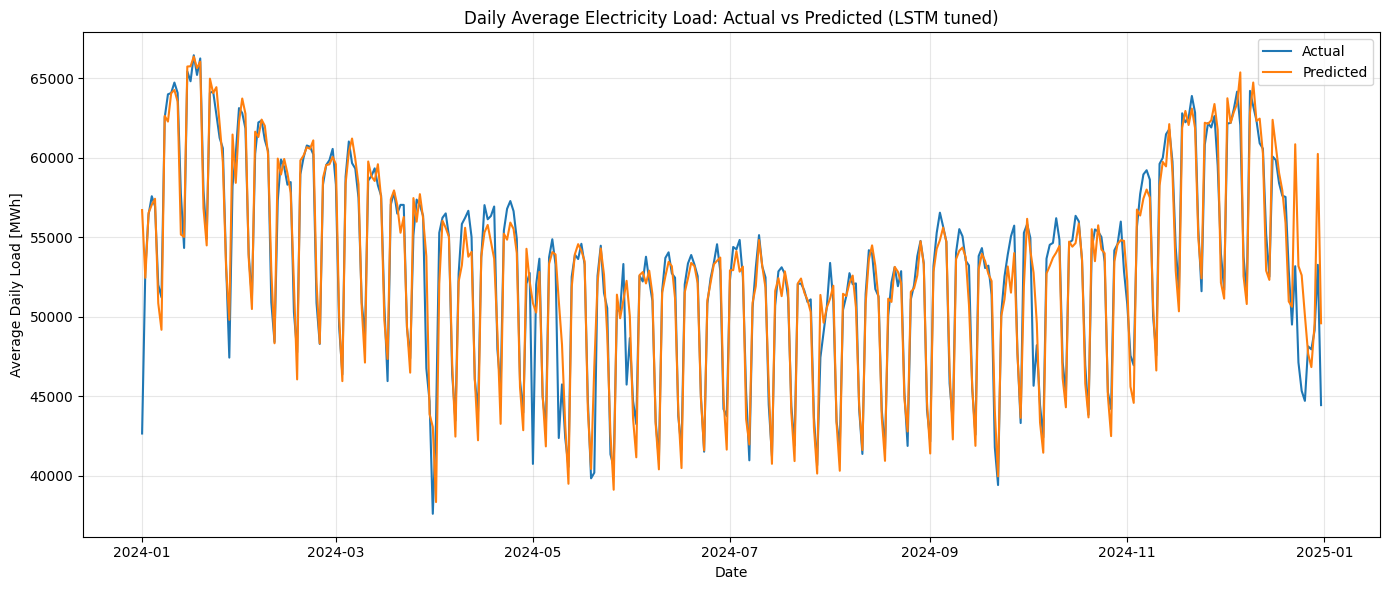

In [17]:
# Build results_df with correct timestamps
results_df = pd.DataFrame({
    "timestamp": timestamps,
    "Actual_Load_MWh": truth,
    "Predicted_Load_MWh": preds
})
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])

# recompute daily_df from the new results_df
daily_df = results_df.resample("D", on="timestamp").mean()

plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual")
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted")
plt.title("Daily Average Electricity Load: Actual vs Predicted (LSTM tuned)")
plt.xlabel("Date")
plt.ylabel("Average Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Key Findings – Daily Average Electricity Load (LSTM, Test Set)

- The **predicted daily average electricity load closely tracks the actual load** over the test period, indicating strong overall forecasting accuracy at an aggregated daily level.

- **Seasonal patterns** are well captured by the LSTM model, with higher load levels during winter months and lower consumption during spring and summer clearly reflected in the predictions.

- The model successfully reproduces the **weekly demand structure**, visible through recurring troughs that correspond to weekend effects.

- Deviations between actual and predicted values are **generally moderate and short-lived**, suggesting stable generalization rather than systematic bias.

- Slight under- or overestimation can be observed during **extreme load situations**, which is typical for data-driven sequence models and does not dominate overall performance.

- Overall, the visualization confirms that the tuned LSTM model provides **reliable and temporally consistent forecasts** on unseen test data.


### 2. Average RMSE & MAPE per Forecast Step
This section visualizes the average RMSE and MAPE for all 24 forecast horizons to assess how prediction accuracy changes with the forecast step.
The plots reveal how errors evolve as the model predicts further into the future, providing insight into short-term vs. long-term forecast reliability.
Together, they highlight the model’s ability to maintain stable performance while quantifying the gradual increase in uncertainty typical of multi-step forecasting.

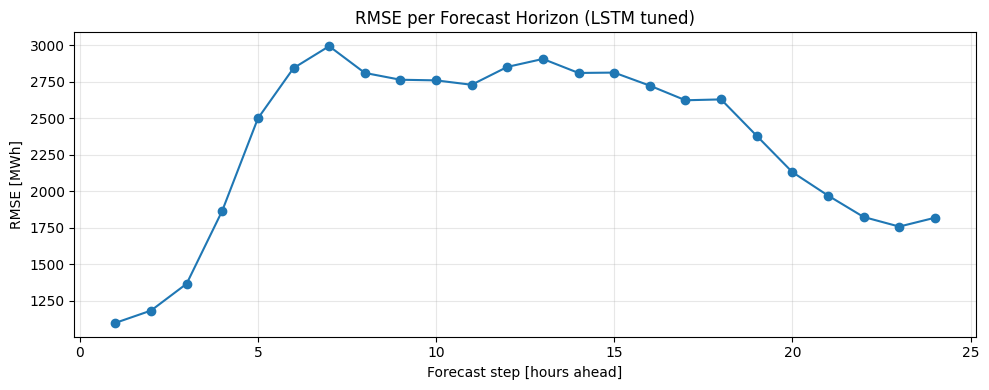

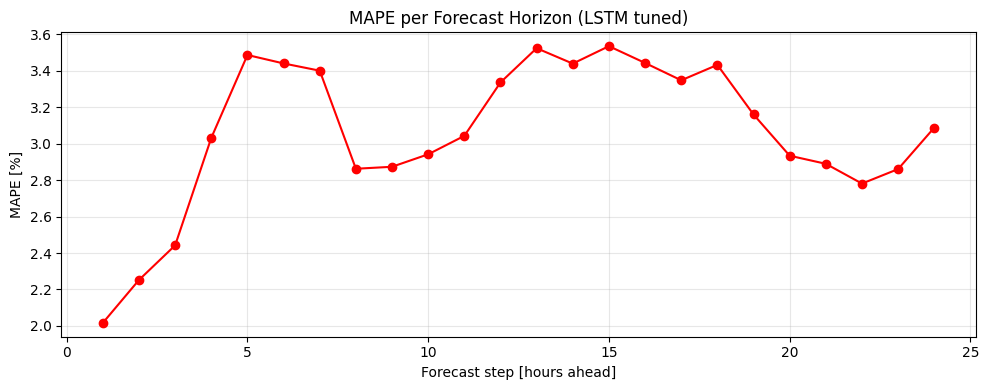

In [18]:
# RMSE per Horizon
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), rmse_h, marker="o")
plt.title("RMSE per Forecast Horizon (LSTM tuned)")
plt.xlabel("Forecast step [hours ahead]")
plt.ylabel("RMSE [MWh]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# MAPE per Horizon
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mape_h, marker="o", color="red")
plt.title("MAPE per Forecast Horizon (LSTM tuned)")
plt.xlabel("Forecast step [hours ahead]")
plt.ylabel("MAPE [%]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Key Findings – Forecast Accuracy across Horizons

- The tuned LSTM model achieves **high short-term accuracy**, with **low RMSE and MAPE values for the first forecast steps (1–3 hours ahead)**, confirming strong near-term predictive performance.

- Both **RMSE and MAPE increase with the forecast horizon**, reflecting the expected accumulation of uncertainty in multi-step time series forecasting.

- The **RMSE reaches its highest values in the mid-horizon range (approximately 12–14 hours ahead)**, indicating the point of maximum absolute prediction error. Beyond this range, RMSE shows a general downward tendency, suggesting stabilization toward daily load patterns.

- The **MAPE remains comparatively stable across medium and long horizons**, mostly fluctuating between **approximately 3.0% and 3.6%**, indicating robust relative accuracy despite increasing absolute errors.

- The absence of sharp spikes or erratic behavior in either metric highlights **stable error propagation** and well-controlled model dynamics across all 24 forecast steps.

- Overall, the combined RMSE and MAPE analysis demonstrates that the tuned LSTM model provides **reliable and consistent multi-horizon forecasts**, maintaining strong performance across both short-term and longer forecast horizons.


### 3. Error Distribution Comparison
This section visualizes the distribution of prediction errors for each forecast horizon (1–24 hours ahead) using boxplots.
The plot highlights how the error spread and bias change with the prediction step, revealing where the model tends to overestimate or underestimate the load.
It provides a deeper understanding of forecast stability and uncertainty across different time horizons.

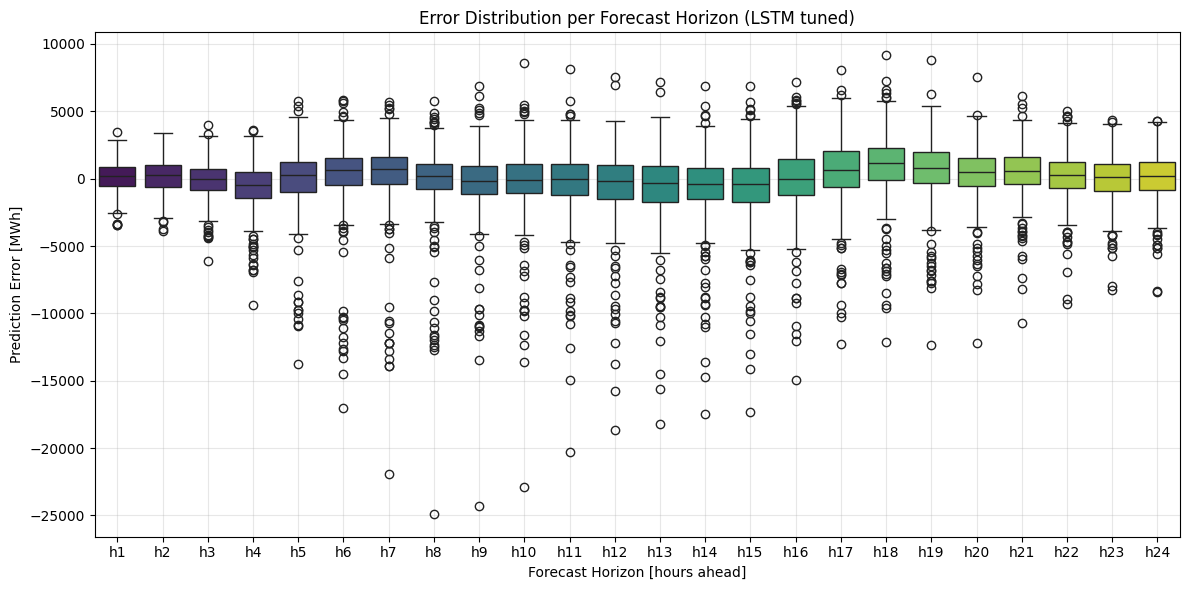

In [19]:
# Error distribution per horizon
errors_df = pd.DataFrame({f"h{h}": errors_h[h] for h in range(1, 25)})

plt.figure(figsize=(12,6))
sns.boxplot(data=errors_df, palette="viridis")
plt.title("Error Distribution per Forecast Horizon (LSTM tuned)")
plt.xlabel("Forecast Horizon [hours ahead]")
plt.ylabel("Prediction Error [MWh]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key Findings – Error Distribution across Forecast Horizons**

- The **median prediction error remains close to zero** across most forecast horizons, indicating the absence of a strong systematic bias in the LSTM forecasts.

- The **spread of the error distribution increases with the forecast horizon**, reflecting growing uncertainty as predictions extend further into the future.

- Mid-range horizons (approximately **6–15 hours ahead**) exhibit the **largest variability and most extreme outliers**, which is consistent with the peak RMSE observed in the horizon-wise error analysis.

- Error distributions remain **approximately symmetric around zero** for most horizons, suggesting balanced over- and underestimation behavior rather than directional bias.

- While **extreme negative and positive errors** occur at several horizons, these outliers are relatively infrequent and do not dominate the overall error structure.

- Overall, the error distributions

## Explainable AI Analysis
To provide insights into the behavior of the LSTM model, two model-agnostic explainability techniques are applied: permutation importance and feature sensitivity analysis. Permutation importance measures the increase in prediction error when the temporal structure of an input feature is randomly permuted, indicating the feature’s relevance for the model’s forecasts. Feature sensitivity analysis perturbs individual input features by a small relative amount and quantifies the resulting change in model predictions. Both methods are applied to a subset of the test sequences to limit computational cost and operate independently of the rolling evaluation procedure.

Top Permutation Importance:
 is_weekend    0.338071
hour          0.239787
lag_1         0.195243
weekday       0.175998
lag_2         0.051975
lag_6         0.047434
lag_24        0.021764
lag_3         0.018226
lag_8760      0.015694
lag_336       0.003673
dtype: float64


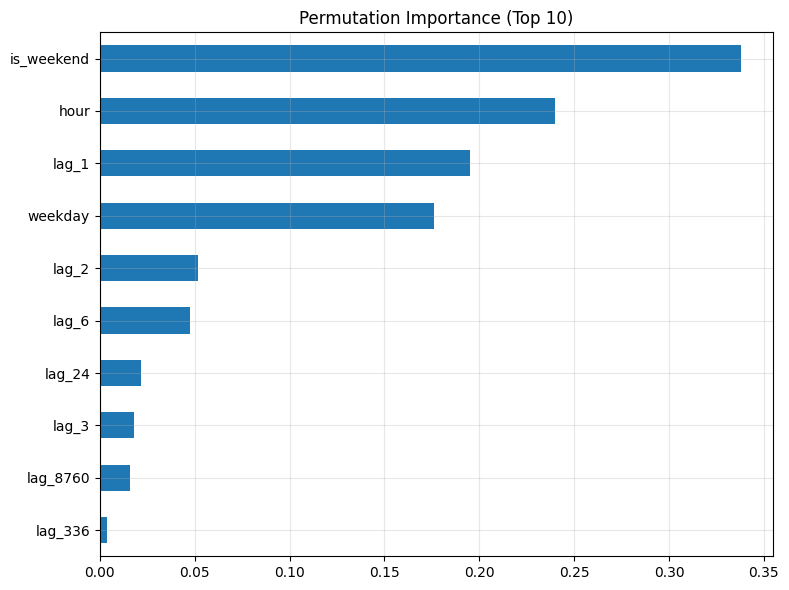

In [20]:
def permutation_importance(model, X, y, feature_cols, n_samples=200):
    """
    Permutation importance for sequence models.
    Each feature is permuted across all samples and timesteps.
    Importance is measured as the increase in RMSE.
    """
    X_base = X[:n_samples].copy()
    y_base = y[:n_samples].copy()

    # Baseline prediction
    baseline_pred = model.predict(X_base, verbose=0)
    baseline_rmse = np.sqrt(
        mean_squared_error(y_base.flatten(), baseline_pred.flatten())
    )

    importances = {}

    for i, feat in enumerate(feature_cols):
        X_perm = X_base.copy()

        # Permute feature across samples and timesteps
        flat_feat = X_perm[:, :, i].flatten()
        np.random.shuffle(flat_feat)
        X_perm[:, :, i] = flat_feat.reshape(X_perm[:, :, i].shape)

        perm_pred = model.predict(X_perm, verbose=0)
        perm_rmse = np.sqrt(
            mean_squared_error(y_base.flatten(), perm_pred.flatten())
        )

        importances[feat] = perm_rmse - baseline_rmse

    return pd.Series(importances).sort_values(ascending=False)

perm_importance = permutation_importance(
    model=model,
    X=X_test_seq,
    y=y_test_seq,
    feature_cols=feature_cols,
    n_samples=200
)

print("Top Permutation Importance:\n", perm_importance.head(10))

plt.figure(figsize=(8,6))
perm_importance.head(10).sort_values().plot(kind="barh")
plt.title("Permutation Importance (Top 10)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Top Sensitivity:
 lag_1         0.053439
hour          0.028500
lag_672       0.024282
lag_2         0.022029
lag_6         0.019603
lag_24        0.017554
lag_3         0.015152
is_weekend    0.014400
lag_8760      0.012331
weekday       0.008605
dtype: float32


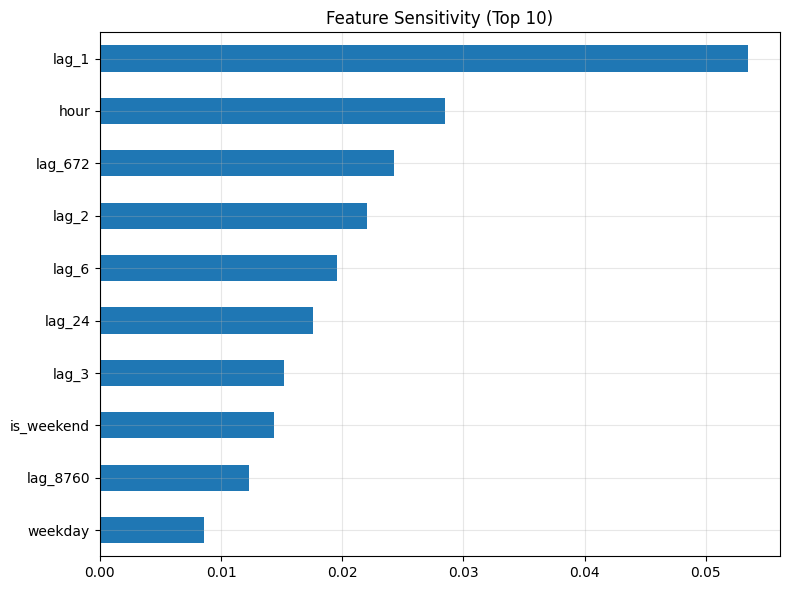

In [21]:
# Feature Sensitivity
def feature_sensitivity(model, X_base, feature_cols, n_samples=50, delta=0.1):
    """
    Feature sensitivity analysis for sequence models.
    Each feature is perturbed by ±delta and the average absolute change
    in model predictions is measured.
    """
    X_ref = X_base[:n_samples].copy()
    sensitivities = {}

    for i, feat in enumerate(feature_cols):
        X_mod = X_ref.copy()

        # Increase feature
        X_mod[:, :, i] *= (1 + delta)
        pred_up = model.predict(X_mod, verbose=0)

        # Decrease feature
        X_mod[:, :, i] = X_ref[:, :, i] * (1 - delta)
        pred_down = model.predict(X_mod, verbose=0)

        sensitivities[feat] = np.mean(np.abs(pred_up - pred_down))

    return pd.Series(sensitivities).sort_values(ascending=False)

sens = feature_sensitivity(
    model=model,
    X_base=X_test_seq,
    feature_cols=feature_cols,
    n_samples=50,
    delta=0.1
)

print("Top Sensitivity:\n", sens.head(10))

plt.figure(figsize=(8,6))
sens.head(10).sort_values().plot(kind="barh")
plt.title("Feature Sensitivity (Top 10)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key Findings – Explainability Analysis (Permutation Importance and Feature Sensitivity)**

- The explainability analysis reveals a **clear dominance of temporal and calendar-based features** in driving the LSTM’s forecasting performance, with consistent patterns across both permutation importance and feature sensitivity measures.

- The **permutation importance analysis highlights calendar-related variables as key drivers**, with **is_weekend**, **hour**, and **weekday** emerging as the most influential features. This confirms the critical role of weekly structure and intra-day timing for accurate electricity load forecasting.

- Short-term lagged features, particularly **lag_1**, also show high importance, indicating that recent load history remains essential for predictive accuracy, though its relative contribution differs across explainability methods.

- The **feature sensitivity analysis emphasizes strong responsiveness to lag-based inputs**, especially **lag_1**, followed by **hour**, suggesting that small perturbations in recent load values and intra-day timing lead to noticeable changes in predicted demand.

- Longer-term lag features such as **lag_24**, **lag_672**, and **lag_8760** exhibit measurable but lower influence, indicating that the LSTM implicitly captures **daily, weekly, and seasonal context** without relying on these signals as primary drivers.

- Overall, the combined explainability results demonstrate that the LSTM primarily leverages **short-term temporal dynamics**, refined by **calendar-based structure and seasonal context**, which aligns well with established domain knowledge in short-term electricity load forecasting and supports the interpretability of the model.


## Overall Conclusion

- The tuned **LSTM-based multi-horizon forecasting model** proves to be a highly effective approach for short-term electricity load prediction, achieving **strong predictive accuracy, stable generalization, and interpretable behavior**.

- Hyperparameter tuning results in a **high-capacity yet well-balanced architecture**, enabling stable convergence without signs of overfitting, as confirmed by smooth training and validation dynamics.

- In terms of **forecasting performance**, the LSTM delivers **excellent short-term accuracy**, while forecast uncertainty increases gradually with the prediction horizon. Horizon-wise RMSE and MAPE analyses indicate **robust performance across all 24 forecast steps**.

- Rolling test evaluation confirms **reliable out-of-sample generalization**, demonstrating that the model performs well under realistic forecasting conditions.

- The **daily average load analysis** shows that seasonal trends, weekly structures, and overall demand levels are reproduced accurately, with only minor deviations during extreme load situations.

- Error distribution analysis reveals **no systematic bias**, with errors remaining centered around zero despite increasing dispersion at longer horizons, indicating stable error propagation.

- Finally, the **explainability analysis** shows that the LSTM primarily relies on **short-term temporal information**, refined by calendar-based features and longer-term contextual lags, supporting the **credibility and interpretability** of the model.

- Overall, the results demonstrate that the tuned LSTM provides a **robust and reliable solution for multi-horizon electricity load forecasting**, effectively complementing tree-based approaches when temporal dependencies are central.